# Diplomatura Universitaria en Inteligencia Artificial
## Trabajo Práctico del Módulo de Visión Computacional

Relizado en conjunto:
[Nuria Sarochar](https://www.linkedin.com/in/nuria-sarochar/)
y
[Damián Cravacuore](https://www.linkedin.com/in/cravacuore/).

Noviembre 2020.



### Configuración del ambiente

In [ ]:
from google.colab import drive
from os import makedirs
from os import path

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [ ]:
drive.mount('/content/gdrive/')

# carpeta donde van a guardar los datos
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Computer Vision/Grupo 02'
makedirs(datasets_folder, exist_ok=True)

# NO TOCAR EL CÓDIGO DE ACÁ ABAJO, ES PARA BAJAR DATOS NUEVOS!
new_datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/DUIA/2021/Computer Vision/'
makedirs(new_datasets_folder, exist_ok=True)
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/DUIA/2021/Computer\ Vision/cifar10.1_v4_data.npy*
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/DUIA/2021/Computer\ Vision/cifar10.1_v4_labels.npy*
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/DUIA/2021/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/DUIA/2021/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_labels.npy
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/DUIA/2021/Computer\ Vision/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
--2021-11-06 02:14:08--  https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy [following]
--2021-11-06 02:14:08--  https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6208640 (5.9M) [application/octet-stream]
Saving to: ‘/content/gdriv

### 1. Acceso a los datos

In [ ]:
# Cargamos los datos y sólo lo transformamos a tensores para ver sus tamaños y calcular mean y std.
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=transforms.ToTensor())
cifar10_validation = datasets.CIFAR10(datasets_folder, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# verificamos tamaños de los grupos
print('Training set size: {}'.format(len(cifar10_training)))
print('Validation set size: {}'.format(len(cifar10_validation)))

data_sample = cifar10_training[0]
print(data_sample[0][0].size()) # vemos tamaño de uno de los tensores (de un único canal)

Training set size: 50000
Validation set size: 10000
torch.Size([32, 32])


In [ ]:
# normalización
imgs = torch.stack([img_t for img_t, _ in cifar10_training], dim=3)
print(imgs.shape)

print(imgs.view(3, -1).size())

# calculamos la media de cada canal
mean = imgs.view(3, -1).mean(dim=1)
print(mean)

# y el desvío
std = imgs.view(3, -1).std(dim=1)
print(std)

torch.Size([3, 32, 32, 50000])
torch.Size([3, 51200000])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [ ]:
list_of_training_transformations = [transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)]
list_of_test_transformations = [transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)]

training_transformations = transforms.Compose(list_of_training_transformations)
test_transformations = transforms.Compose(list_of_test_transformations)

# descargamos los datos de entrenamiento (o los levantamos, si ya están ahí)
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=training_transformations)
# hacemos lo mismo con los de test (que los vamos a usar de datos de validación)
cifar10_validation = datasets.CIFAR10(datasets_folder, train=False, download=True, transform=test_transformations)

# creamos los data loaders
training_loader = DataLoader(cifar10_training, batch_size=32, shuffle=True)
validation_loader = DataLoader(cifar10_validation, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### 2. Implementación de red neuronal convolucional

In [ ]:
class OurNetcita(nn.Module):
  '''
  Clase que implementa una arquitectura de red neuronal para el problema de 
  clasificación de imágenes en 10 clases usando datos de CIFAR10
  '''

  def __init__(self):
    '''
    Constructor de la clase
    '''
    super().__init__()
    
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv1 = nn.BatchNorm2d(num_features=16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv2 = nn.BatchNorm2d(num_features=32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv3 = nn.BatchNorm2d(num_features=64)

    self.fc1 = nn.Linear(64 * 4 * 4, 32, bias = False)
    self.batch_norm_fc1 = nn.BatchNorm1d(num_features=32)
    # y de esas 32 features generaremos 10 scores
    self.fc2 = nn.Linear(32, 10)
    # capa softmax para obtener probabilidades
    self.final_activation = nn.Softmax(dim=1)


  def forward(self, inputs):
    '''
    Método que implementa el forward pass
    '''
    out = F.max_pool2d(F.leaky_relu(self.batch_norm_conv1(self.conv1(inputs))), 2)
    out = F.max_pool2d(F.leaky_relu(self.batch_norm_conv2(self.conv2(out))), 2)
    out = F.max_pool2d(F.leaky_relu(self.batch_norm_conv3(self.conv3(out))), 2)
    # convertimos el activamos map en un vector
    out = out.view(-1, 64 * 4 * 4)
    # primera capa fully connected y función de activación
    out = F.leaky_relu(self.batch_norm_fc1(self.fc1(out)))
    out = F.dropout(out, p=0.05)
    # última capa
    out = self.fc2(out)
    return out


  def predict(self, inputs):
    # devolvemos el softmax de los resultados
    return self.final_activation(self.__call__(inputs))

### Algunas funciones auxiliares

In [ ]:
def get_num_parameters(model):
  '''
  Nos devuelve una lista con la cantidad de parámetros entrenables de un modelo
  '''
  numel_list = [p.numel()
                for p in model.parameters()
                if p.requires_grad == True]

  return numel_list

def print_model_parameters_amount(model):
  '''
  Imprime cantidad de parámetros con algunos separadores para destacarlo
  '''
  print("  ")
  print("  ")
  print("============ Número de parámetros ===============")
  numel_list = get_num_parameters(model)
  # imprimimos el número total de capas
  print(sum(numel_list), numel_list)
  print("=================================================")
  print("  ")

def get_device():
  return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def print_running_device():
  gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else ""
  print(f'======== Running in {device} - {gpu_name} ========')

### 3. Entrenamiento y validación de la red

In [ ]:
device = get_device()
print_running_device()

model = OurNetcita()
print_model_parameters_amount(model)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
n_epochs = 50

# movemos todo lo que haga falta a la GPU
model = model.to(device)
loss_fn = loss_fn.to(device)

# -----------------
# TRAINING LOOP
# -----------------

# inicializamos listas para guardar los valores de loss function de entrenamiento
# y validación, además del accuracy sobre los mismos.
per_epoch_training_loss_values       = np.zeros(n_epochs)
per_epoch_training_accuracy_values   = np.zeros(n_epochs)
per_epoch_validation_loss_values     = np.zeros(n_epochs)
per_epoch_validation_accuracy_values = np.zeros(n_epochs)


for epoch in range(n_epochs):
  if (((epoch % 10 ) == 0) & (epoch != 0)):
    learning_rate = learning_rate * 0.1
    print(f'Learning Rate = {learning_rate}')
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-3)
  # ponemos el modelo en modo entrenamiento
  model.train()

  # inicializamos una lista para ir guardando los valores de loss por batch
  training_loss_values = np.zeros(len(training_loader))
  
  # iteramos por cada batch
  i=0
  total_train = 0
  correct_train = 0
  for imgs, labels in training_loader:
    imgs = imgs.to(device)
    labels = labels.view(-1).to(device)
    # obtenemos la respuesta del modelo
    outputs = model(imgs)
    # calculamos la loss
    loss = loss_fn(outputs, labels)
    # mandamos a 0 los gradientes
    optimizer.zero_grad()
    # hacemos un backward pass
    loss.backward()
    # y un paso del optimizador para actualizar los parámetros
    optimizer.step()
    # registramos el valor de la loss
    training_loss_values[i]=float(loss.cpu())
    i=i+1
    
    # le aplicamos la activation function a las salidas para obtener scores
    scores = model.final_activation(outputs)
    # obtenemos la predicción de la clase
    _, predicted = torch.max(scores.cpu(), dim=1)
    labels = labels.cpu()
    total_train += labels.shape[0]
    correct_train += int((predicted == labels).sum())


  # VALIDACIÓN
  # lo ponemos en modo evaluación
  model.eval()

  # inicializamos una lista para guardar los valores de loss por batch en los 
  # datos de validación
  validation_loss_values = np.zeros(len(validation_loader))
  # y dos variables para medir la cantidad de muestras totales y la cantidad de
  # aciertos
  total_val   = 0
  correct_val = 0

  # no vamos a calcular gradientes
  with torch.no_grad():
    # iteramos por cada batch
    i=0
    for imgs, labels in validation_loader:
      # pasamos imágenes y labels al dispositivo donde estemos corriendo
      imgs = imgs.to(device)
      labels = labels.view(-1).to(device)
      # obtenemos la respuesta del modelo
      outputs = model(imgs)
      # calculamos la loss
      loss = loss_fn(outputs, labels)
      # registramos el valor de la loss
      validation_loss_values[i]=float(loss.cpu())
      i=i+1
      # le aplicamos la activation function a las salidas para obtener scores
      scores = model.final_activation(outputs)
      # obtenemos la predicción de la clase
      _, predicted = torch.max(scores.cpu(), dim=1)
      labels = labels.cpu()
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())

  # actualizamos las estadísticas
  per_epoch_training_loss_values[epoch]       = np.mean(training_loss_values)
  per_epoch_training_accuracy_values[epoch]   = correct_train / total_train
  per_epoch_validation_loss_values[epoch]     = np.mean(validation_loss_values)
  per_epoch_validation_accuracy_values[epoch] = correct_val / total_val
  
  if (epoch % 5) == 0:
    print('Epoch: {}'.format(epoch+1))
    print('- Training loss: {:.4f}'.format(per_epoch_training_loss_values[epoch]))
    print('- Validation loss: {:.4f}'.format(per_epoch_validation_loss_values[epoch]))
    print('- Validation accuracy: {:.4f}'.format(per_epoch_validation_accuracy_values[epoch]))

======== Running in cuda:0 - Tesla K80 ========
  
  
============ Número de parámetros ===============
56858 [432, 16, 16, 4608, 32, 32, 18432, 64, 64, 32768, 32, 32, 320, 10]
  
Epoch: 1
- Training loss: 1.4924
- Validation loss: 1.1785
- Validation accuracy: 0.5953
Epoch: 6
- Training loss: 0.7545
- Validation loss: 0.8713
- Validation accuracy: 0.6950
Learning Rate = 0.001
Epoch: 11
- Training loss: 0.5236
- Validation loss: 0.7358
- Validation accuracy: 0.7453
Epoch: 16
- Training loss: 0.4667
- Validation loss: 0.7403
- Validation accuracy: 0.7470
Learning Rate = 0.0001
Epoch: 21
- Training loss: 0.4317
- Validation loss: 0.7430
- Validation accuracy: 0.7471
Epoch: 26
- Training loss: 0.4275
- Validation loss: 0.7463
- Validation accuracy: 0.7439
Learning Rate = 1e-05
Epoch: 31
- Training loss: 0.4223
- Validation loss: 0.7424
- Validation accuracy: 0.7487
Epoch: 36
- Training loss: 0.4206
- Validation loss: 0.7509
- Validation accuracy: 0.7456
Learning Rate = 1.0000000000000002e

# Gráficos de estadísticas

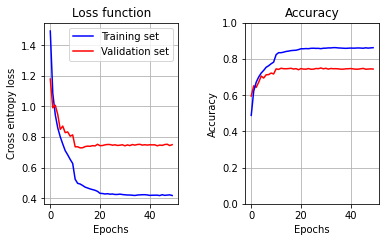

In [ ]:
# creamos plots para la loss y el accuracy
fig, axes = plt.subplots(1, 2)
# graficamos la evolución de la loss de entrenamiento y la de validación
axes[0].plot(per_epoch_training_loss_values, color='blue')
axes[0].plot(per_epoch_validation_loss_values, color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Cross entropy loss')
axes[0].grid(True)
axes[0].legend(['Training set', 'Validation set'])
axes[0].set_title('Loss function')
# graficamos la evolución del accuracy
axes[1].plot(per_epoch_validation_accuracy_values, color='red')
axes[1].plot(per_epoch_training_accuracy_values, color='blue')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].set_title('Accuracy')
axes[1].set_ylim([0, 1.0])
fig.tight_layout(pad=3.0)

### 4. Evaluación sobre nuevos datos

In [ ]:
# accedemos a los datos
images = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_data.npy'))
labels = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_labels.npy'))
# imprimimos los tamaños
print(images.shape)
print(labels.shape)

(2021, 32, 32, 3)
(2021,)


In [ ]:
model = model.eval()
N = images.shape[0]
predictions = torch.zeros(N, dtype=torch.uint8)
with torch.no_grad():
  for i, image in enumerate(images):
    image_tensor = test_transformations(image).unsqueeze(0).to(device)
    raw = model.predict(image_tensor.float())
    pred_tmp = torch.argmax(raw).cpu().item()
    predictions[i] = pred_tmp

predictions_list = predictions.tolist()

accuracy = accuracy_score(labels, predictions_list)
print(f'Test data accuracy: {accuracy}')

Test data accuracy: 0.599208312716477


In [ ]:
# guardamos los parámetros del modelo
torch.save(model.state_dict(), path.join(datasets_folder, 'vfinal.pt'))

### Conclusiones

El modelo actualmente presentado es un modelo que todavía podría aprender, le faltan parámetros para ello. En una próxima implementación podría modificarse de forma tal que la cantidad de parámetros sea mayor, como quitanto el primer max pooling.

